In [1]:
# import pyspark class Row from module sql
from pyspark.sql import *

# Create Example Data - Departments and Employees

# Create the Departments
department1 = Row(id='123456', name='Computer Science')
department2 = Row(id='789012', name='Mechanical Engineering')
department3 = Row(id='345678', name='Theater and Drama')
department4 = Row(id='901234', name='Indoor Recreation')

# Create the Employees
Employee = Row("firstName", "lastName", "email", "salary")
employee1 = Employee('michael', 'armbrust', 'no-reply@berkeley.edu', 100000)
employee2 = Employee('xiangrui', 'meng', 'no-reply@stanford.edu', 120000)
employee3 = Employee('matei', None, 'no-reply@waterloo.edu', 140000)
employee4 = Employee(None, 'wendell', 'no-reply@berkeley.edu', 160000)

# Create the DepartmentWithEmployees instances from Departments and Employees
departmentWithEmployees1 = Row(department=department1, employees=[employee1, employee2])
departmentWithEmployees2 = Row(department=department2, employees=[employee3, employee4])
departmentWithEmployees3 = Row(department=department3, employees=[employee1, employee4])
departmentWithEmployees4 = Row(department=department4, employees=[employee2, employee3])

print(department1)
print(employee2)
print(departmentWithEmployees1.employees[0].email)


Row(id='123456', name='Computer Science')
Row(firstName='xiangrui', lastName='meng', email='no-reply@stanford.edu', salary=120000)
no-reply@berkeley.edu

In [2]:
# Create DataFrame from list of rows

departmentsWithEmployeesSeq1 = [departmentWithEmployees1, departmentWithEmployees2]
df1 = sqlContext.createDataFrame(departmentsWithEmployeesSeq1)

display(df1)


department,employees
"List(123456, Computer Science)","List(List(michael, armbrust, no-reply@berkeley.edu, 100000), List(xiangrui, meng, no-reply@stanford.edu, 120000))"
"List(789012, Mechanical Engineering)","List(List(matei, null, no-reply@waterloo.edu, 140000), List(null, wendell, no-reply@berkeley.edu, 160000))"


In [3]:
# Create a second DataFrame from a list of rows

departmentsWithEmployeesSeq2 = [departmentWithEmployees3, departmentWithEmployees4]
df2 = sqlContext.createDataFrame(departmentsWithEmployeesSeq2)

display(df2)

department,employees
"List(345678, Theater and Drama)","List(List(michael, armbrust, no-reply@berkeley.edu, 100000), List(null, wendell, no-reply@berkeley.edu, 160000))"
"List(901234, Indoor Recreation)","List(List(xiangrui, meng, no-reply@stanford.edu, 120000), List(matei, null, no-reply@waterloo.edu, 140000))"


In [4]:
# Union of 2 DataFrames

unionDF = df1.unionAll(df2)
display(unionDF)


department,employees
"List(123456, Computer Science)","List(List(michael, armbrust, no-reply@berkeley.edu, 100000), List(xiangrui, meng, no-reply@stanford.edu, 120000))"
"List(789012, Mechanical Engineering)","List(List(matei, null, no-reply@waterloo.edu, 140000), List(null, wendell, no-reply@berkeley.edu, 160000))"
"List(345678, Theater and Drama)","List(List(michael, armbrust, no-reply@berkeley.edu, 100000), List(null, wendell, no-reply@berkeley.edu, 160000))"
"List(901234, Indoor Recreation)","List(List(xiangrui, meng, no-reply@stanford.edu, 120000), List(matei, null, no-reply@waterloo.edu, 140000))"


In [5]:
# Write the unioned DataFrame to a Parquet file

# Remove the file if it exists
dbutils.fs.rm("/tmp/databricks-df-example.parquet", True)
unionDF.write.parquet("/tmp/databricks-df-example.parquet")


In [6]:
# Read a DataFrame from the Parquet file

parquetDF = sqlContext.read.parquet("/tmp/databricks-df-example.parquet")
display(parquetDF)

department,employees
"List(345678, Theater and Drama)","List(List(michael, armbrust, no-reply@berkeley.edu, 100000), List(null, wendell, no-reply@berkeley.edu, 160000))"
"List(789012, Mechanical Engineering)","List(List(matei, null, no-reply@waterloo.edu, 140000), List(null, wendell, no-reply@berkeley.edu, 160000))"
"List(901234, Indoor Recreation)","List(List(xiangrui, meng, no-reply@stanford.edu, 120000), List(matei, null, no-reply@waterloo.edu, 140000))"
"List(123456, Computer Science)","List(List(michael, armbrust, no-reply@berkeley.edu, 100000), List(xiangrui, meng, no-reply@stanford.edu, 120000))"


In [7]:
# Explode the employees column
from pyspark.sql.functions import explode

df = parquetDF.select(explode("employees").alias("e"))
explodeDF = df.selectExpr("e.firstName", "e.lastName", "e.email", "e.salary")

display(explodeDF)



firstName,lastName,email,salary
michael,armbrust,no-reply@berkeley.edu,100000
null,wendell,no-reply@berkeley.edu,160000
matei,null,no-reply@waterloo.edu,140000
null,wendell,no-reply@berkeley.edu,160000
xiangrui,meng,no-reply@stanford.edu,120000
matei,null,no-reply@waterloo.edu,140000
michael,armbrust,no-reply@berkeley.edu,100000
xiangrui,meng,no-reply@stanford.edu,120000


In [8]:
# Use filter() to return only the rows that match the given predicate

filterDF = explodeDF.filter(explodeDF.firstName == "xiangrui").sort(explodeDF.lastName)
display(filterDF)

firstName,lastName,email,salary
xiangrui,meng,no-reply@stanford.edu,120000
xiangrui,meng,no-reply@stanford.edu,120000


In [9]:
# More filters

from pyspark.sql.functions import col, asc

# Use `|` instead of `or`
filterDF = explodeDF.filter((col("firstName") == "xiangrui") | (col("firstName") == "michael")).sort(asc("lastName"))
display(filterDF)


firstName,lastName,email,salary
michael,armbrust,no-reply@berkeley.edu,100000
michael,armbrust,no-reply@berkeley.edu,100000
xiangrui,meng,no-reply@stanford.edu,120000
xiangrui,meng,no-reply@stanford.edu,120000


In [10]:
# Use where()-clause to filter

whereDF = explodeDF.where((col("firstName") == "xiangrui") | (col("firstName") == "michael")).sort(asc("lastName"))
display(whereDF)


firstName,lastName,email,salary
michael,armbrust,no-reply@berkeley.edu,100000
michael,armbrust,no-reply@berkeley.edu,100000
xiangrui,meng,no-reply@stanford.edu,120000
xiangrui,meng,no-reply@stanford.edu,120000


In [11]:
# Retrieve only rows with missing firstName or lastName

filterNonNullDF = explodeDF.filter(col("firstName").isNull() | col("lastName").isNull()).sort("email")
display(filterNonNullDF)

# Replace null values with -- using DataFrame Na functions
nonNullDF = explodeDF.fillna("--")
display(nonNullDF)


firstName,lastName,email,salary
michael,armbrust,no-reply@berkeley.edu,100000
--,wendell,no-reply@berkeley.edu,160000
matei,--,no-reply@waterloo.edu,140000
--,wendell,no-reply@berkeley.edu,160000
xiangrui,meng,no-reply@stanford.edu,120000
matei,--,no-reply@waterloo.edu,140000
michael,armbrust,no-reply@berkeley.edu,100000
xiangrui,meng,no-reply@stanford.edu,120000


In [12]:
# Example aggregations using agg() and countDistinct()

from pyspark.sql.functions import countDistinct

countDistinctDF = explodeDF.select("firstName", "lastName")\
  .groupBy("firstName", "lastName")\
  .agg(countDistinct("firstName"))

display(countDistinctDF)


firstName,lastName,count(DISTINCT firstName)
null,wendell,0
matei,null,1
xiangrui,meng,1
michael,armbrust,1


In [13]:
# Compare the DataFrame and SQL Query Physical Plans (Hint: They should be the same.)

countDistinctDF.explain()

== Physical Plan ==
*(2) HashAggregate(keys=[firstName#2430, lastName#2431], functions=[count(distinct firstName#2430)])
+- *(2) HashAggregate(keys=[firstName#2430, lastName#2431, firstName#2430], functions=[])
 +- Exchange hashpartitioning(firstName#2430, lastName#2431, firstName#2430, 200)
 +- *(1) HashAggregate(keys=[firstName#2430, lastName#2431, firstName#2430], functions=[])
 +- *(1) Project [e#2428.firstName AS firstName#2430, e#2428.lastName AS lastName#2431]
 +- *(1) Generate explode(employees#2421), false, [e#2428]
 +- *(1) FileScan parquet [employees#2421] Batched: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex[dbfs:/tmp/databricks-df-example.parquet], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<employees:array<struct<firstName:string,lastName:string,email:string,salary:bigint>>>

In [14]:
# Now check this result
# register the DataFrame as a temp table so that we can query it using SQL
explodeDF.registerTempTable("databricks_df_example")

# Perform the same query as the DataFrame above and return ``explain``
countDistinctDF_sql = sqlContext.sql("SELECT firstName, lastName, count(distinct firstName) as distinct_first_names FROM databricks_df_example GROUP BY firstName, lastName")

countDistinctDF_sql.explain()


== Physical Plan ==
*(2) HashAggregate(keys=[firstName#2430, lastName#2431], functions=[count(distinct firstName#2430)])
+- *(2) HashAggregate(keys=[firstName#2430, lastName#2431, firstName#2430], functions=[])
 +- Exchange hashpartitioning(firstName#2430, lastName#2431, firstName#2430, 200)
 +- *(1) HashAggregate(keys=[firstName#2430, lastName#2431, firstName#2430], functions=[])
 +- *(1) Project [e#2428.firstName AS firstName#2430, e#2428.lastName AS lastName#2431]
 +- *(1) Generate explode(employees#2421), false, [e#2428]
 +- *(1) FileScan parquet [employees#2421] Batched: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex[dbfs:/tmp/databricks-df-example.parquet], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<employees:array<struct<firstName:string,lastName:string,email:string,salary:bigint>>>

In [15]:
# Sum up all salaries
salarySumDF = explodeDF.agg({"salary" : "sum"})
display(salarySumDF)


sum(salary)
1040000


In [16]:
# Show type 
type(explodeDF.salary)

Out[ 19 ]: pyspark.sql.column.Column

In [17]:
# Print the summary statistics for the salaries.

explodeDF.describe("salary").show()


+-------+-----------------+
summary| salary|
+-------+-----------------+
 count| 8|
 mean| 130000.0|
 stddev|23904.57218668787|
 min| 100000|
 max| 160000|
+-------+-----------------+

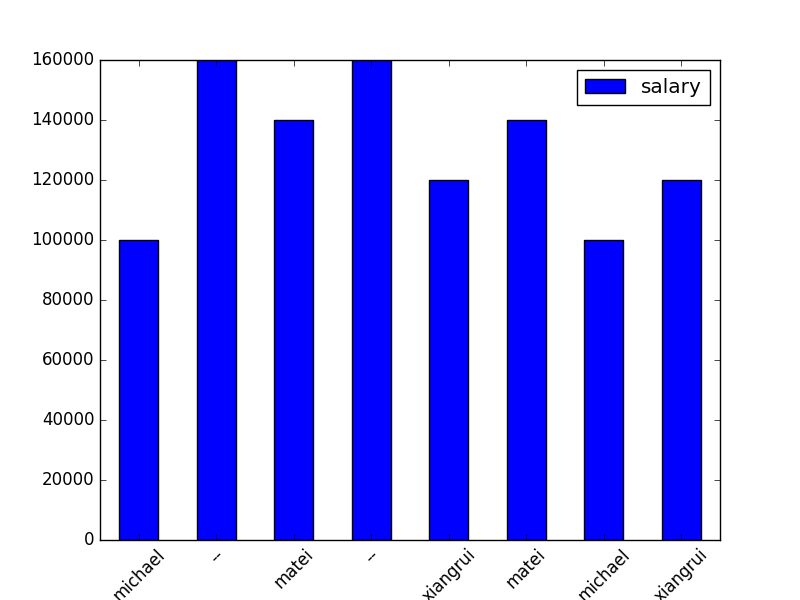

In [18]:
# Make some nice plots using Pandas and Matplotlib

import pandas as pd
import matplotlib.pyplot as plt
plt.clf()
pdDF = nonNullDF.toPandas()
pdDF.plot(x='firstName', y='salary', kind='bar', rot=45)
display()
